In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
from feature_engine.selection import SmartCorrelatedSelection
from sklearn.tree import DecisionTreeRegressor

import utils

In [2]:
# list of regions. Taking two from each cluster and two low lat non cluster regions
REGIONS = [194, 270, 287, 207, 62, 241, 366, 387, 223, 19, 163]
# REGIONS = [83, 143, 223, 44, 173, 321, 366, 383, 122, 279, 14, 95, 237, 26, 166, 86,
# 						387, 61, 202, 287, 207, 361, 137, 184, 36, 19, 9, 163, 16, 270, 194, 82,
# 						62, 327, 293, 241, 107, 55, 111]
start_date = pd.to_datetime('2009-07-20')
end_date = pd.to_datetime('2017-12-31')

# Starting by just looking at the Solar Wind data

In [3]:
# loading solar wind data from OMNI
omni = pd.read_feather('../data/SW/omniData.feather')
omni.set_index('Epoch', inplace=True)
omni.index = pd.to_datetime(omni.index)
omni = omni.loc[start_date:end_date]
omni['logT'] = np.log10(omni['T'])
omni.drop(['T'], axis=1, inplace=True)
omni.dropna(inplace=True)


In [4]:
old_storm_dates_df = utils.storm_extract(omni)
twins_storm_times_df = utils.storm_extract(omni, lead=30, recovery=10, twins=True)

Date_UTC not in columns. Check to make sure index is datetime not integer.
Date_UTC not in columns. Check to make sure index is datetime not integer.
                    dates
0     2009-07-21 00:00:00
1     2009-07-21 00:10:00
2     2009-07-21 00:19:59
3     2009-07-21 00:30:00
4     2009-07-21 00:39:59
...                   ...
33960 2017-11-07 08:20:00
33961 2017-11-07 08:40:00
33962 2017-11-07 08:49:59
33963 2017-11-07 09:00:00
33964 2017-11-07 09:10:00

[33965 rows x 1 columns]


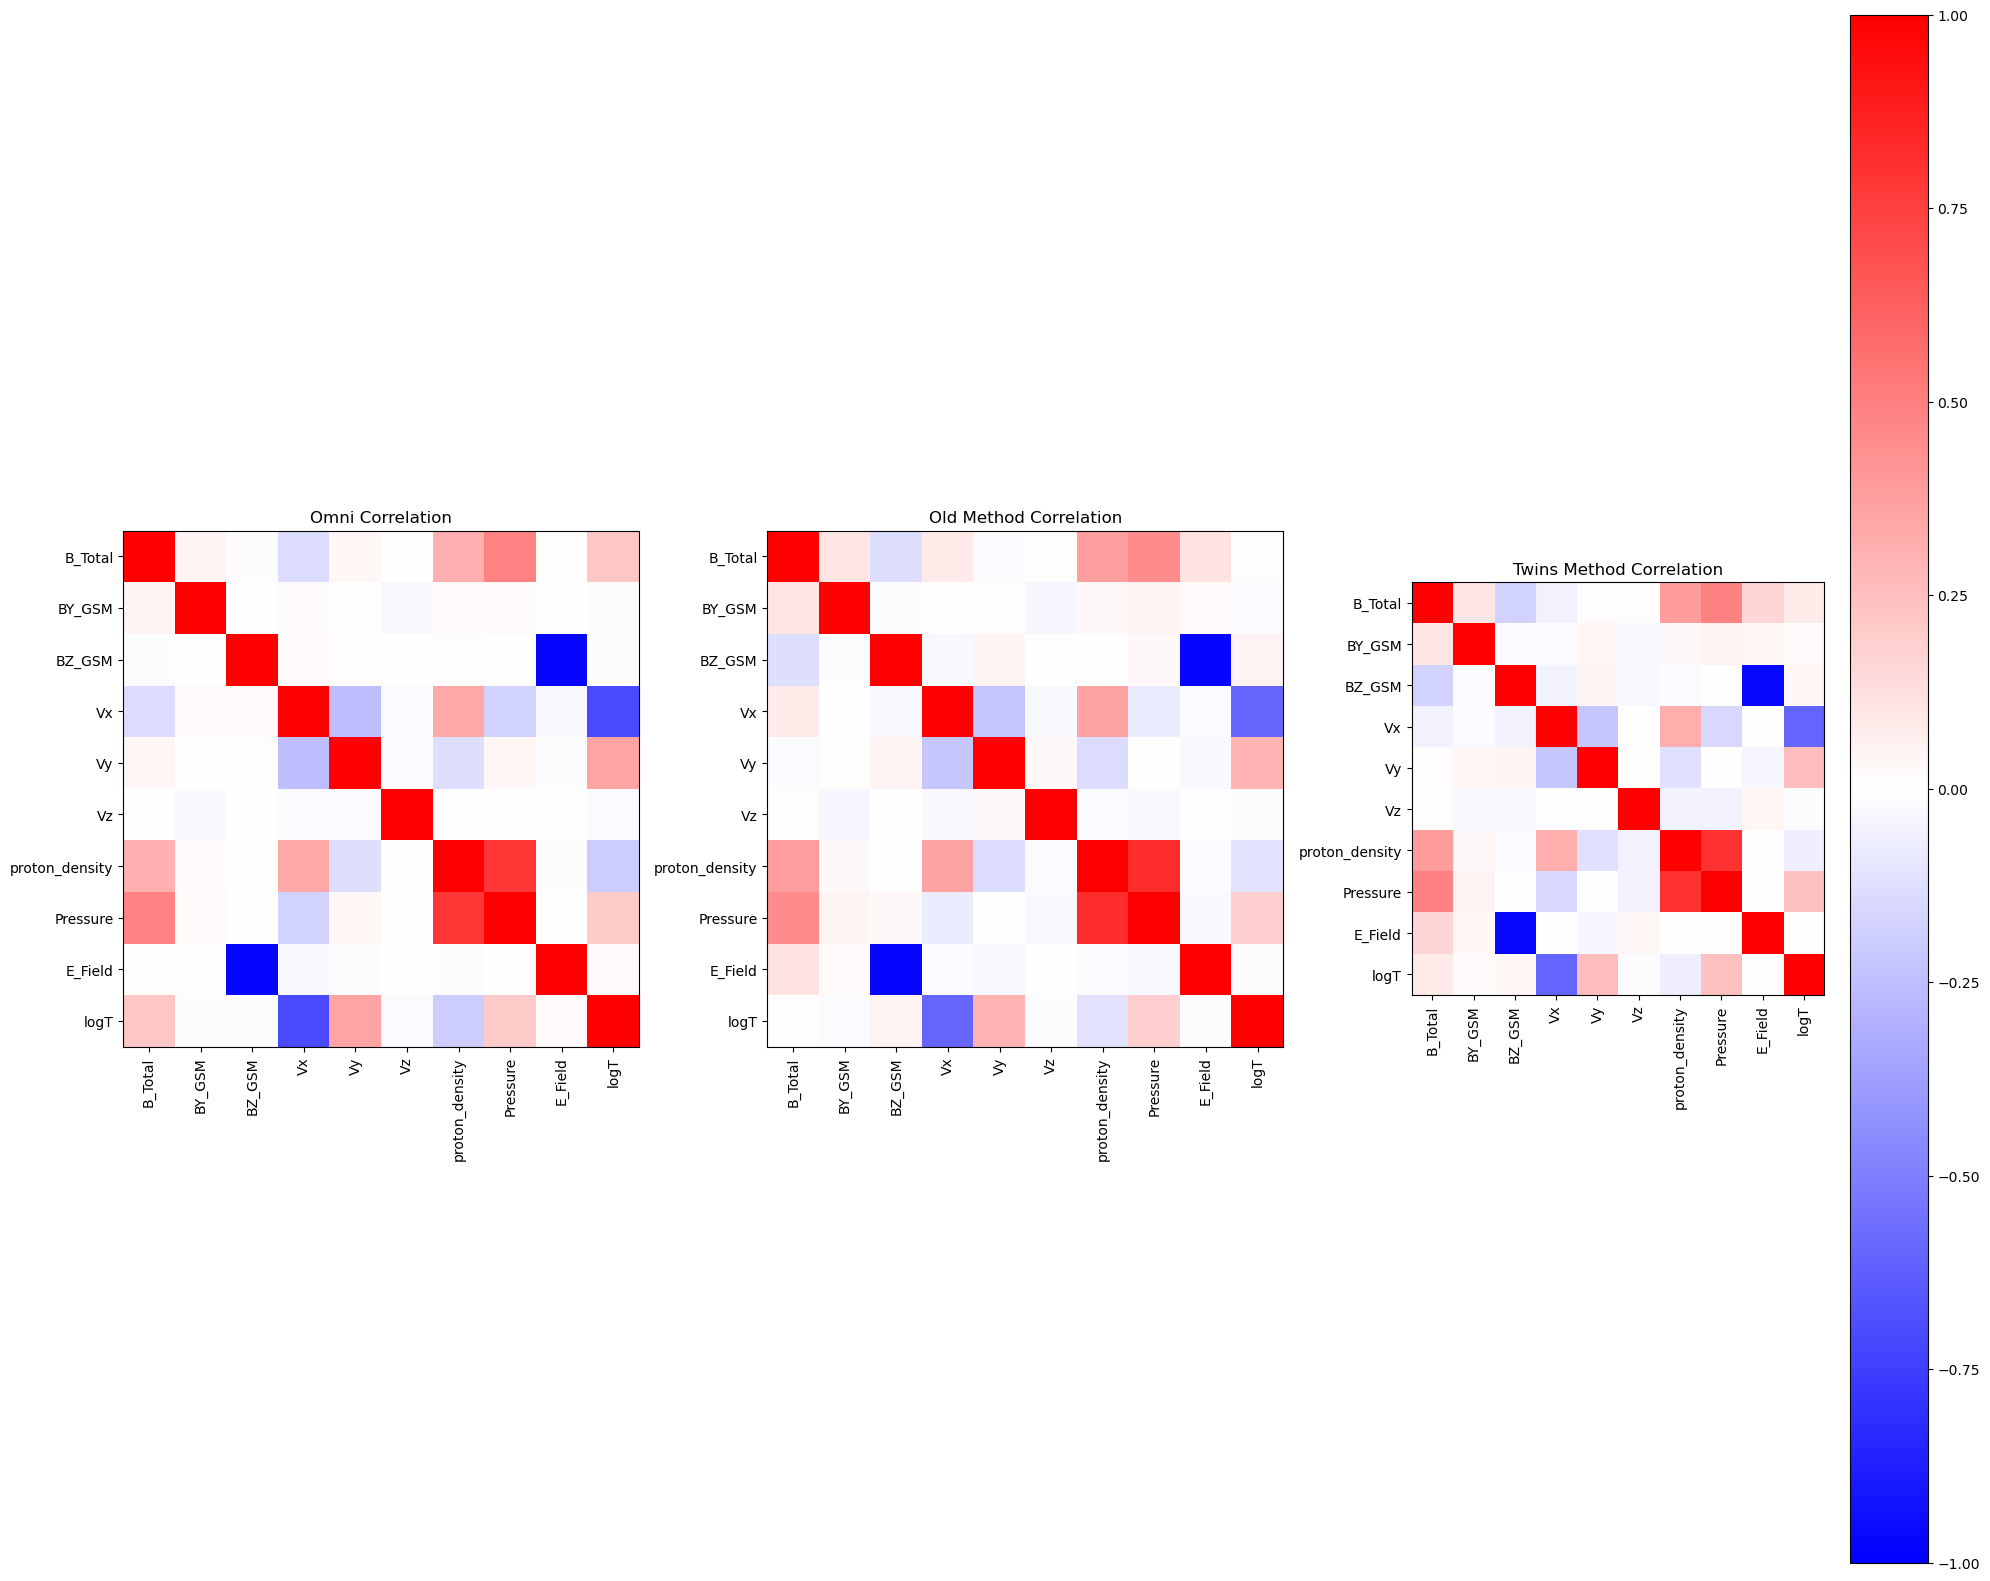

In [5]:
# showing correlation tables for each method

fig = plt.figure(figsize=(20,20))
ax0 = fig.add_subplot(131)
plt.imshow(omni.corr(), cmap='bwr', vmin=-1, vmax=1)
ax0.set_title('Omni Correlation')
plt.xticks(np.arange(0, len(omni.columns)), omni.columns, rotation=90)
plt.yticks(np.arange(0, len(omni.columns)), omni.columns)

ax1 = fig.add_subplot(132)
plt.imshow(old_storm_dates_df.corr(), cmap='bwr', vmin=-1, vmax=1)
ax1.set_title('Old Method Correlation')
plt.xticks(np.arange(0, len(old_storm_dates_df.columns)), old_storm_dates_df.columns, rotation=90)
plt.yticks(np.arange(0, len(old_storm_dates_df.columns)), old_storm_dates_df.columns)

ax2 = fig.add_subplot(133)
plt.imshow(twins_storm_times_df.corr(), cmap='bwr', vmin=-1, vmax=1)
ax2.set_title('Twins Method Correlation')
plt.xticks(np.arange(0, len(twins_storm_times_df.columns)), twins_storm_times_df.columns, rotation=90)
plt.yticks(np.arange(0, len(twins_storm_times_df.columns)), twins_storm_times_df.columns)
plt.colorbar()

plt.tight_layout()
plt.show()




In [6]:
print(f'Old method df shape: {old_storm_dates_df.shape}')
print(f'Using TWINS dates shape: {twins_storm_times_df.shape}')

Old method df shape: (661458, 10)
Using TWINS dates shape: (1357059, 10)


In [7]:
omni_var = omni.var()
old_method_var = old_storm_dates_df.var()
twins_method_var = twins_storm_times_df.var()
omni_x = [i-0.5 for i in range(1, 2*len(omni_var), 2)]
old_x = [i for i in range(1, 2*len(old_method_var), 2)]
twins_x = [i+0.5 for i in range(1, 2*len(twins_method_var), 2)]

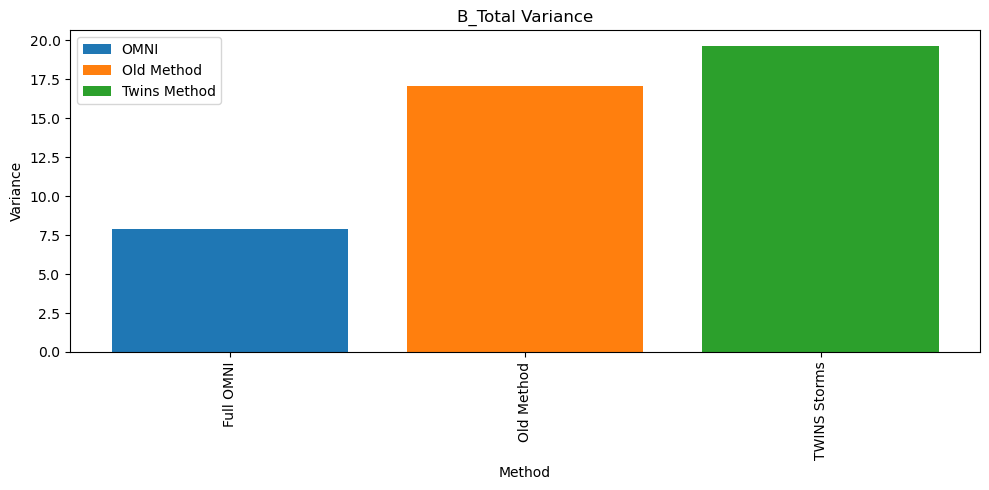

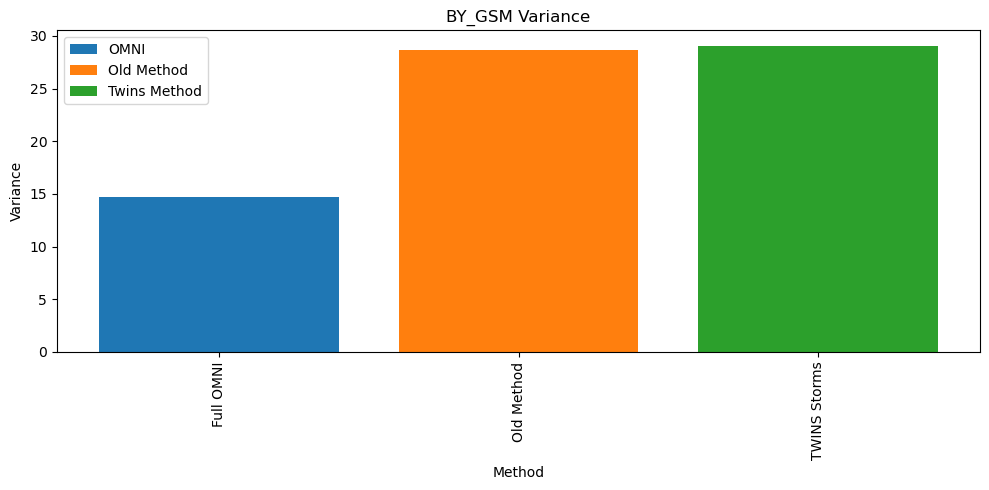

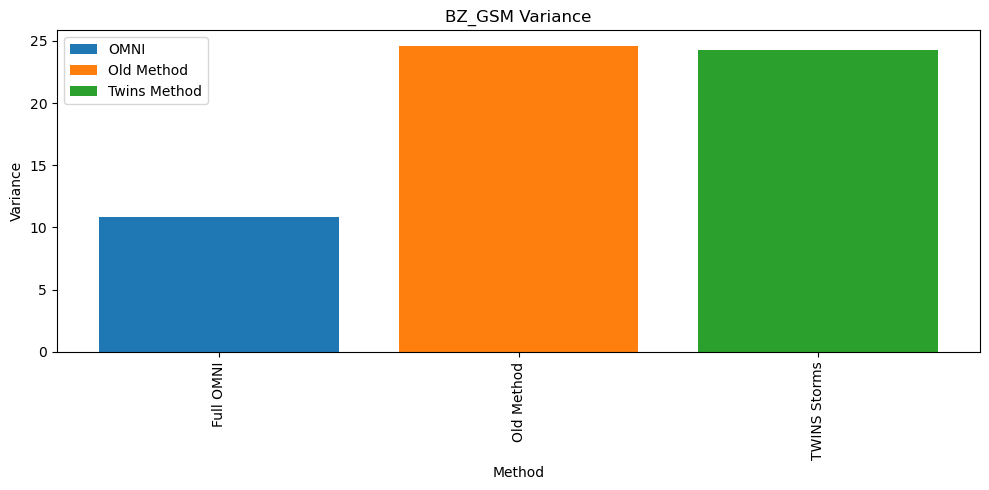

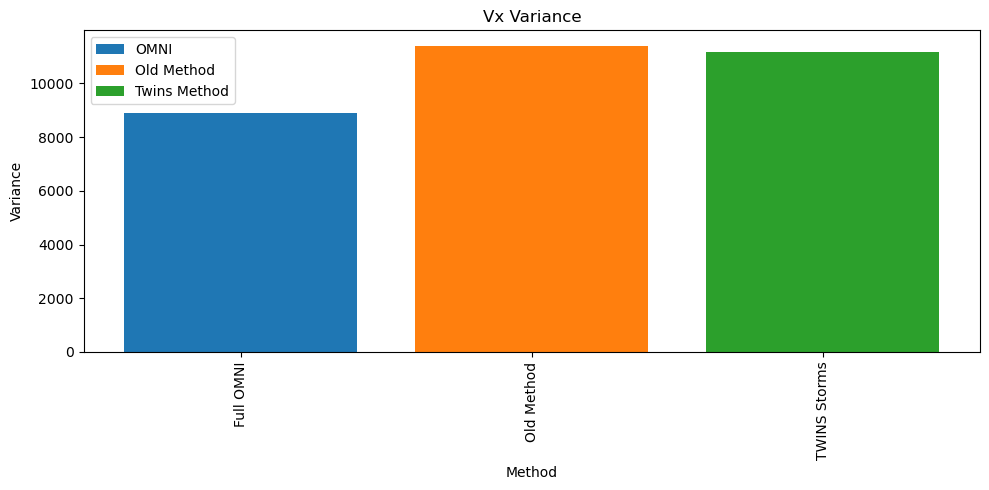

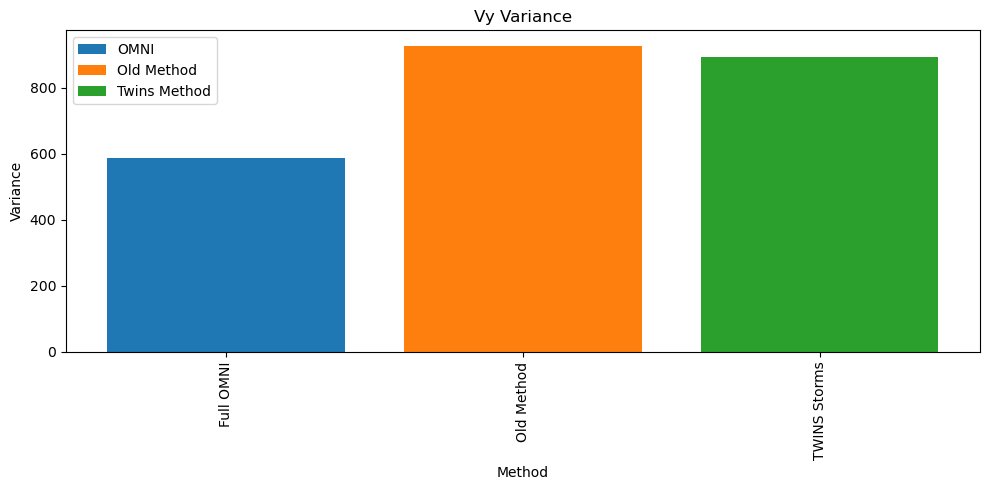

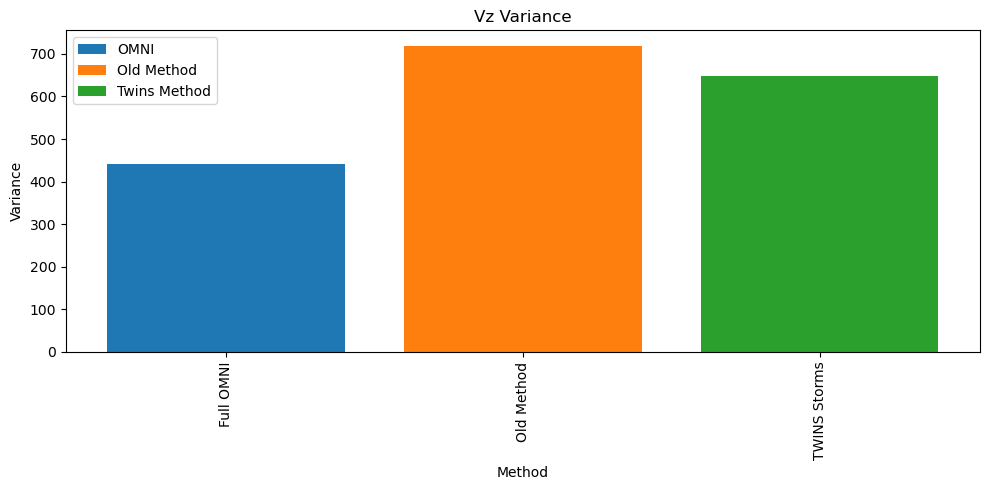

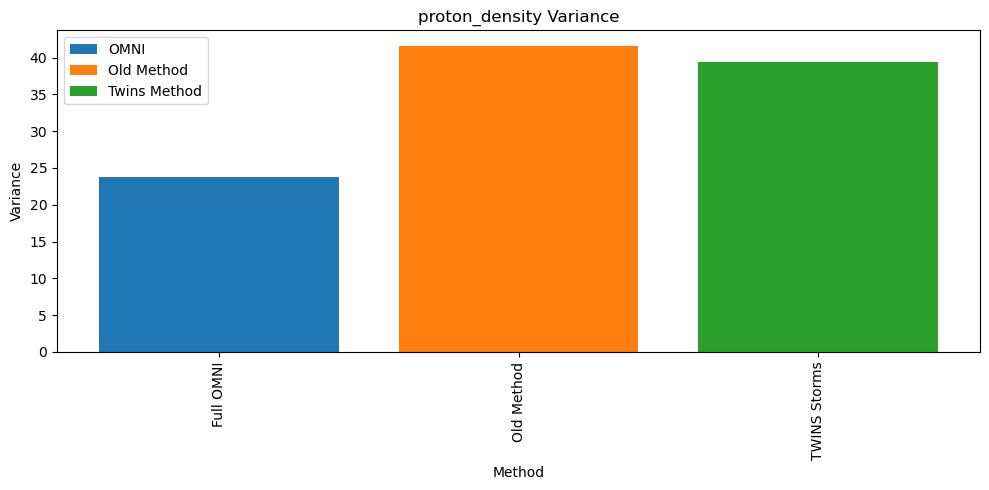

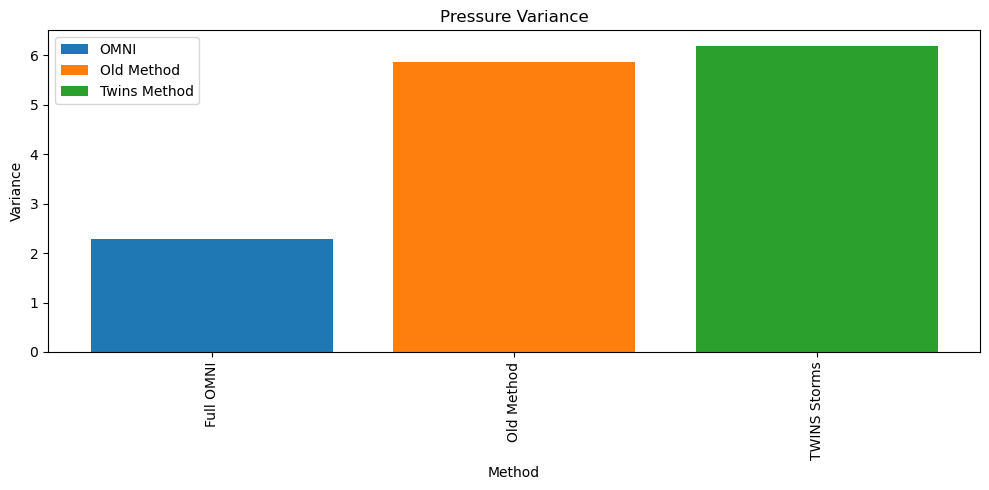

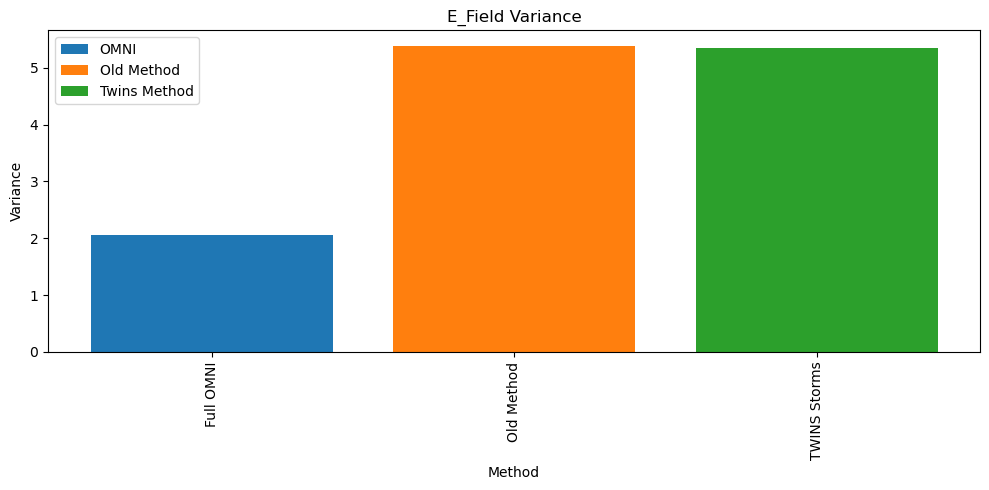

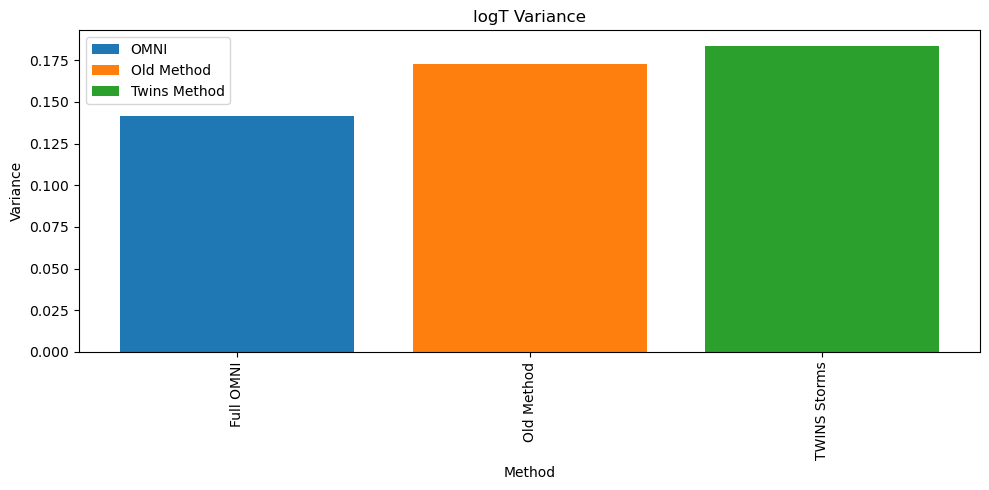

In [8]:
for i in range(len(omni_var)):

	# plotting the varianes of each method for each feature normalized to the mean in a bar graph
	fig = plt.figure(figsize=(10, 5))
	ax = fig.add_subplot(111)
	ax.bar(1, omni_var[i], label='OMNI')
	ax.bar(2, old_method_var[i], label='Old Method')
	ax.bar(3, twins_method_var[i], label='Twins Method')
	ax.set_xticks([1,2,3])
	ax.set_xticklabels(['Full OMNI', 'Old Method', 'TWINS Storms'], rotation=90)
	ax.set_title(f'{omni_var.index[i]} Variance')
	ax.set_ylabel('Variance')
	ax.set_xlabel('Method')
	ax.legend()
	plt.tight_layout()
	plt.show()


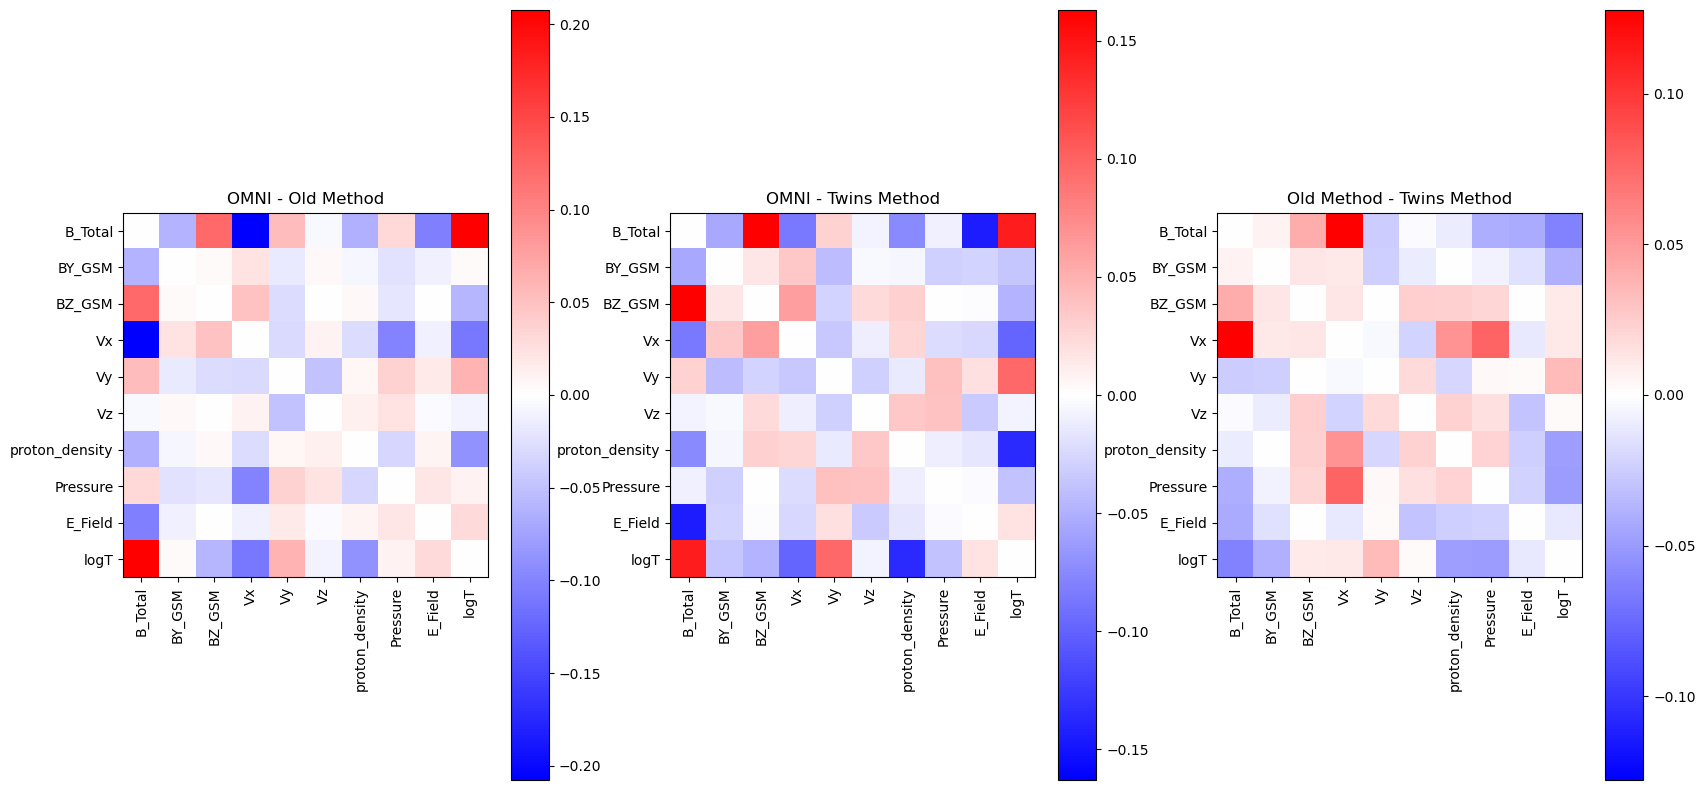

In [9]:
omni_corr = omni.corr()
old_method_corr = old_storm_dates_df.corr()
twins_method_corr = twins_storm_times_df.corr()

omni_old_corr_diff = omni_corr - old_method_corr
omni_twins_corr_diff = omni_corr - twins_method_corr
old_twins_corr_diff = old_method_corr - twins_method_corr

# plotting the difference in correlation between the methods
fig = plt.figure(figsize=(20, 10))
ax0 = fig.add_subplot(131)
plt.imshow(omni_old_corr_diff, cmap='bwr', vmax=omni_old_corr_diff.max().max(), vmin=-omni_old_corr_diff.max().max())
plt.colorbar()
plt.title('OMNI - Old Method')
plt.xticks(np.arange(0, len(omni_old_corr_diff.columns)), omni_old_corr_diff.columns, rotation=90)
plt.yticks(np.arange(0, len(omni_old_corr_diff.columns)), omni_old_corr_diff.columns)

ax1 = fig.add_subplot(132)
plt.imshow(omni_twins_corr_diff, cmap='bwr', vmax=omni_twins_corr_diff.max().max(), vmin=-omni_twins_corr_diff.max().max())
plt.colorbar()
plt.title('OMNI - Twins Method')
plt.xticks(np.arange(0, len(omni_twins_corr_diff.columns)), omni_twins_corr_diff.columns, rotation=90)
plt.yticks(np.arange(0, len(omni_twins_corr_diff.columns)), omni_twins_corr_diff.columns)

ax2 = fig.add_subplot(133)
plt.imshow(old_twins_corr_diff, cmap='bwr', vmax=old_twins_corr_diff.max().max(), vmin=-old_twins_corr_diff.max().max())
plt.colorbar()
plt.title('Old Method - Twins Method')
plt.xticks(np.arange(0, len(old_twins_corr_diff.columns)), old_twins_corr_diff.columns, rotation=90)
plt.yticks(np.arange(0, len(old_twins_corr_diff.columns)), old_twins_corr_diff.columns)

plt.show()

In [10]:
def combining_stations_into_regions(stations, rsd, features, mean=False, std=False, maximum=False, median=False):

	start_time = pd.to_datetime('2009-07-20')
	end_time = pd.to_datetime('2017-12-31')
	twins_time_period = pd.date_range(start=start_time, end=end_time, freq='min')

	regional_df = pd.DataFrame(index=twins_time_period)

	# creating a dataframe for each feature with the twins time period as the index and storing them in a dict
	feature_dfs = {}
	if features is not None:
		for feature in features:
			feature_dfs[feature] = pd.DataFrame(index=twins_time_period)

	for stat in stations:
		df = utils.loading_supermag(stat)
		df = df[start_time:end_time]
		if features is not None:
			for feature in features:
				feature_dfs[feature][f'{stat}_{feature}'] = df[feature]
	if features is not None:
		for feature in features:
			if mean:
				if feature == 'N' or feature == 'E':
					regional_df[f'{feature}_mean'] = feature_dfs[feature].abs().mean(axis=1)
				else:
					regional_df[f'{feature}_mean'] = feature_dfs[feature].mean(axis=1)
			if std:
				regional_df[f'{feature}_std'] = feature_dfs[feature].std(axis=1)
			if maximum:
				if feature == 'N' or feature == 'E':
					regional_df[f'{feature}_max'] = feature_dfs[feature].abs().max(axis=1)
				else:
					regional_df[f'{feature}_max'] = feature_dfs[feature].max(axis=1)
			if median:
				if feature == 'N' or feature == 'E':
					regional_df[f'{feature}_median'] = feature_dfs[feature].abs().median(axis=1)
				else:
					regional_df[f'{feature}_median'] = feature_dfs[feature].median(axis=1)

	indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=15)

	regional_df['rsd'] = rsd['max_rsd']['max_rsd']
	regional_df['rolling_rsd'] = rsd['max_rsd']['max_rsd'].rolling(indexer, min_periods=1).max()
	regional_df['MLT'] = rsd['max_rsd']['MLT']
	regional_df['cosMLT'] = np.cos(regional_df['MLT'] * 2 * np.pi * 15 / 360)
	regional_df['sinMLT'] = np.sin(regional_df['MLT'] * 2 * np.pi * 15 / 360)


	return regional_df


def loading_data():

	# loading all the datasets and dictonaries

	regions, stats = utils.loading_dicts()

	# reduce the regions dict to be only the ones that have keys in the region_numbers list
	regions = {f'region_{reg}': regions[f'region_{reg}'] for reg in REGIONS}

	# Getting regions data for each region
	for region in regions.keys():

		# getting dbdt and rsd data for the region
		regions[region]['regional_df'] = combining_stations_into_regions(regions[region]['station'], stats[region], features=['dbht', 'MAGNITUDE', 'N', 'E', 'theta'], mean=True, std=True, maximum=True, median=True)

		# getting the mean latitude for the region and attaching it to the regions dictionary
		regions[region]['mean_lat'] = utils.getting_mean_lat(regions[region]['station'])


	return regions


def merging_solarwind_and_supermag(main_df, target_df):

	main_df = pd.merge(main_df, target_df, left_index=True, \
							right_index=True, how='inner')

	return main_df


def smart_correlations(df, target):

	smart_correlation = SmartCorrelatedSelection(threshold=0.75, method='pearson', scoring='explained_variance',
													 selection_method='model_performance', estimator=DecisionTreeRegressor())
	smart_correlation.fit(df, target)
	corr_feature_names = smart_correlation.features_to_drop_

	return corr_feature_names


def finding_smart_correlations(full, old, twins):

	full_target = full['rolling_rsd']
	old_target = old['rolling_rsd']
	twins_target = twins['rolling_rsd']

	to_drop = ['rolling_rsd']
	if 'MLT' in full.columns:
		to_drop.append('MLT')
	if 'rsd' in full.columns:
		to_drop.append('rsd')

	full.drop(to_drop, axis=1, inplace=True)
	old.drop(to_drop, axis=1, inplace=True)
	twins.drop(to_drop, axis=1, inplace=True)

	full_corr_features = smart_correlations(full, full_target)
	old_corr_features = smart_correlations(old, old_target)
	twins_corr_features = smart_correlations(twins, twins_target)

	return full_corr_features, old_corr_features, twins_corr_features



In [11]:
regions = loading_data()
correlation_results = {region: {'mean_lat':regions[region]['mean_lat']} for region in regions.keys()}

for region in regions:

	temp_onmi = omni.copy()
	temp_old = old_storm_dates_df.copy()
	temp_twins = twins_storm_times_df.copy()

	temp_omni = merging_solarwind_and_supermag(temp_onmi, regions[region]['regional_df']['rolling_rsd'])
	temp_old = merging_solarwind_and_supermag(temp_old, regions[region]['regional_df']['rolling_rsd'])
	temp_twins = merging_solarwind_and_supermag(temp_twins, regions[region]['regional_df']['rolling_rsd'])

	temp_omni.dropna(inplace=True)
	temp_old.dropna(inplace=True)
	temp_twins.dropna(inplace=True)

	omni_corr_features, old_corr_features, twins_corr_features = finding_smart_correlations(temp_omni, temp_old, temp_twins)

	correlation_results[region]['omni_corr_features'] = omni_corr_features
	correlation_results[region]['old_corr_features'] = old_corr_features
	correlation_results[region]['twins_corr_features'] = twins_corr_features


Loading regional dictionaries....
Loading station RED....
Loading station MEA....
Loading station C06....
Loading station T36....
Loading station RED....
Loading station MEA....
Loading station C06....
Loading station T36....
Loading station C10....
Loading station T03....
Loading station T43....
Loading station LET....
Loading station C10....
Loading station T03....
Loading station T43....
Loading station LET....
Loading station THY....
Loading station BDV....
Loading station WIC....
Loading station NCK....
Loading station HRB....
Loading station THY....
Loading station BDV....
Loading station WIC....
Loading station NCK....
Loading station HRB....
Loading station VYH....
Loading station LON....
Loading station THY....
Loading station WIC....
Loading station NCK....
Loading station HRB....
Loading station P01....
Loading station VYH....
Loading station LON....
Loading station THY....
Loading station WIC....
Loading station NCK....
Loading station HRB....
Loading station P01....
Loadin

In [12]:
for key in correlation_results.keys():
	print(f'{key}:{correlation_results[key]}\n')


region_194:{'mean_lat': 60.951233, 'omni_corr_features': ['proton_density', 'E_Field'], 'old_corr_features': ['proton_density', 'E_Field'], 'twins_corr_features': ['proton_density', 'E_Field']}

region_270:{'mean_lat': 56.751698, 'omni_corr_features': ['proton_density', 'E_Field'], 'old_corr_features': ['proton_density', 'E_Field'], 'twins_corr_features': ['proton_density', 'E_Field']}

region_287:{'mean_lat': 42.96383, 'omni_corr_features': ['proton_density', 'E_Field'], 'old_corr_features': ['Pressure', 'E_Field'], 'twins_corr_features': ['proton_density', 'E_Field']}

region_207:{'mean_lat': 41.94854, 'omni_corr_features': ['proton_density', 'E_Field'], 'old_corr_features': ['proton_density', 'E_Field'], 'twins_corr_features': ['proton_density', 'E_Field']}

region_62:{'mean_lat': 75.40473, 'omni_corr_features': ['proton_density', 'E_Field'], 'old_corr_features': ['proton_density', 'E_Field'], 'twins_corr_features': ['proton_density', 'E_Field']}

region_241:{'mean_lat': 72.87939, '

In [13]:
for region, vals in correlation_results.items():
	print(f'{region}: {vals}')

region_194: {'mean_lat': 60.951233, 'omni_corr_features': ['proton_density', 'E_Field'], 'old_corr_features': ['proton_density', 'E_Field'], 'twins_corr_features': ['proton_density', 'E_Field']}
region_270: {'mean_lat': 56.751698, 'omni_corr_features': ['proton_density', 'E_Field'], 'old_corr_features': ['proton_density', 'E_Field'], 'twins_corr_features': ['proton_density', 'E_Field']}
region_287: {'mean_lat': 42.96383, 'omni_corr_features': ['proton_density', 'E_Field'], 'old_corr_features': ['Pressure', 'E_Field'], 'twins_corr_features': ['proton_density', 'E_Field']}
region_207: {'mean_lat': 41.94854, 'omni_corr_features': ['proton_density', 'E_Field'], 'old_corr_features': ['proton_density', 'E_Field'], 'twins_corr_features': ['proton_density', 'E_Field']}
region_62: {'mean_lat': 75.40473, 'omni_corr_features': ['proton_density', 'E_Field'], 'old_corr_features': ['proton_density', 'E_Field'], 'twins_corr_features': ['proton_density', 'E_Field']}
region_241: {'mean_lat': 72.87939, 

### It would seem that the logT is the only thing that changes between the OMNI only and the reduced data sets.

# On the the regions themselves!

In [14]:
regions = loading_data()
mag_correlation_dict = {}
mag_variances = {region: {'mean_lat':regions[region]['mean_lat']} for region in regions.keys()}


for region in regions:

	print(region)
	print(regions[region]['regional_df'].columns)

	temp_full_df = regions[region]['regional_df'].copy()
	temp_old_storm_dates_df = utils.storm_extract(regions[region]['regional_df'])
	temp_twins_storm_times_df = utils.storm_extract(regions[region]['regional_df'], lead=30, recovery=10, twins=True)

	print(f'Initial region df shape: {regions[region]["regional_df"].shape}')
	print(f'Old method df shape: {temp_old_storm_dates_df.shape}')
	print(f'Using TWINS dates shape: {temp_twins_storm_times_df.shape}')

	temp_full_df.dropna(inplace=True)
	temp_old_storm_dates_df.dropna(inplace=True)
	temp_twins_storm_times_df.dropna(inplace=True)


	full_corr, old_corr, twins_corr = finding_smart_correlations(temp_full_df, temp_old_storm_dates_df, temp_twins_storm_times_df)

	mag_correlation_dict[region] = {'full_corr': full_corr, 'old_corr': old_corr, 'twins_corr': twins_corr}

	full_var = temp_full_df.var()
	old_var = temp_old_storm_dates_df.var()
	twins_var = temp_twins_storm_times_df.var()

	mag_variances[region]['full_var'] = full_var
	mag_variances[region]['old_var'] = old_var
	mag_variances[region]['twins_var'] = twins_var


Loading regional dictionaries....
Loading station RED....
Loading station MEA....
Loading station C06....
Loading station T36....
Loading station RED....
Loading station MEA....
Loading station C06....
Loading station T36....
Loading station C10....
Loading station T03....
Loading station T43....
Loading station LET....
Loading station C10....
Loading station T03....
Loading station T43....
Loading station LET....
Loading station THY....
Loading station BDV....
Loading station WIC....
Loading station NCK....
Loading station HRB....
Loading station THY....
Loading station BDV....
Loading station WIC....
Loading station NCK....
Loading station HRB....
Loading station VYH....
Loading station LON....
Loading station THY....
Loading station WIC....
Loading station NCK....
Loading station HRB....
Loading station P01....
Loading station VYH....
Loading station LON....
Loading station THY....
Loading station WIC....
Loading station NCK....
Loading station HRB....
Loading station P01....
Loadin

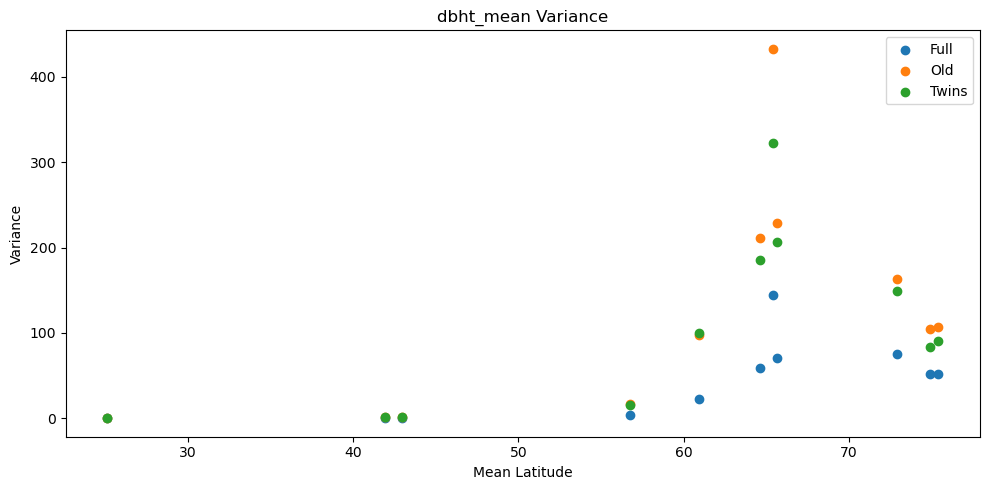

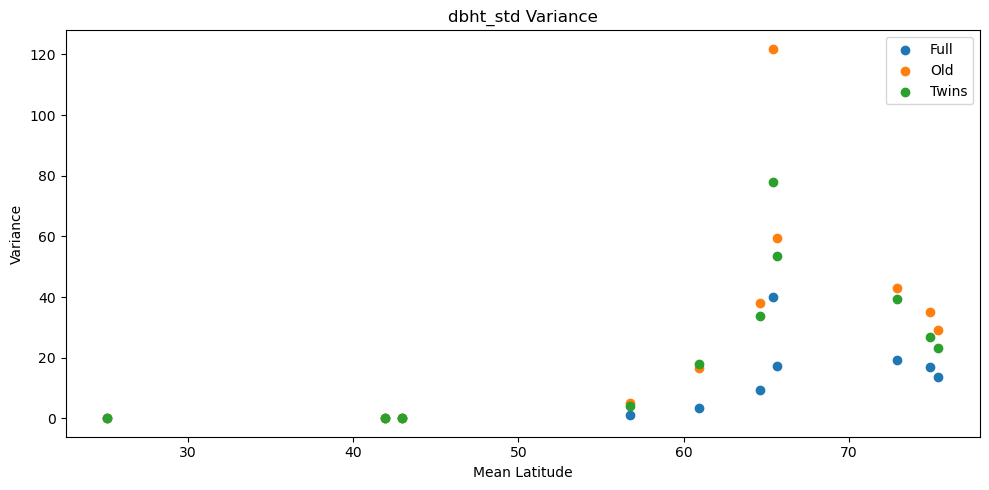

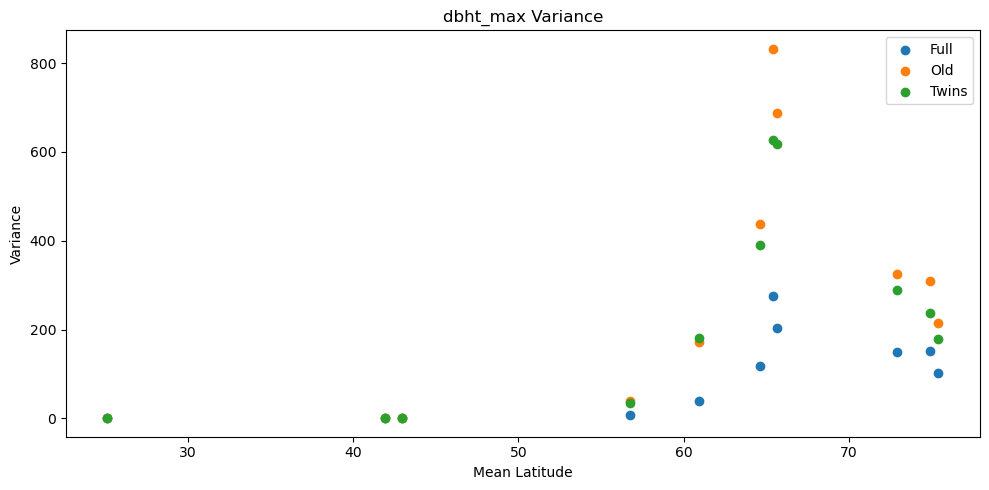

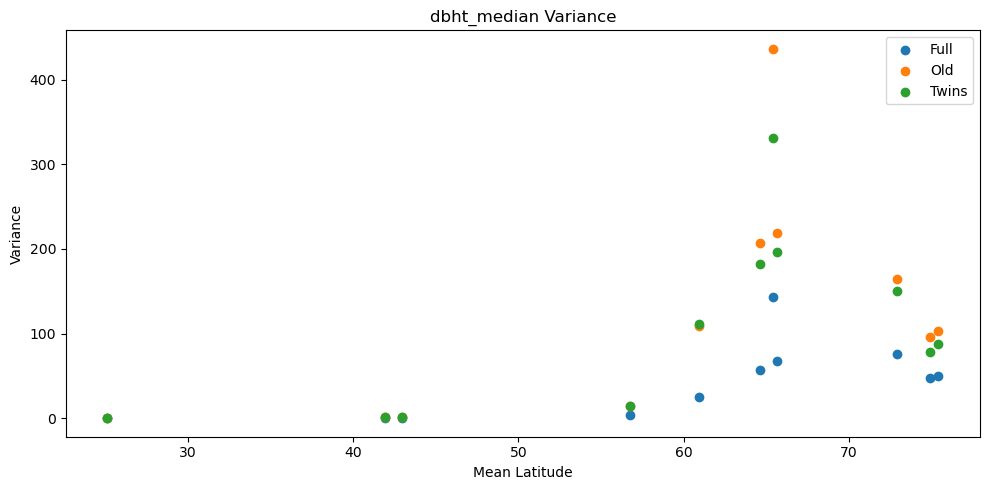

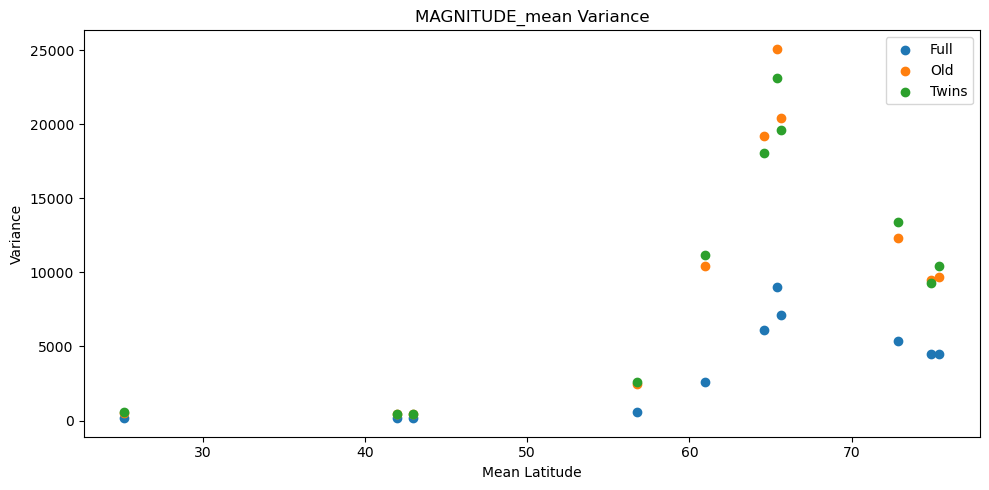

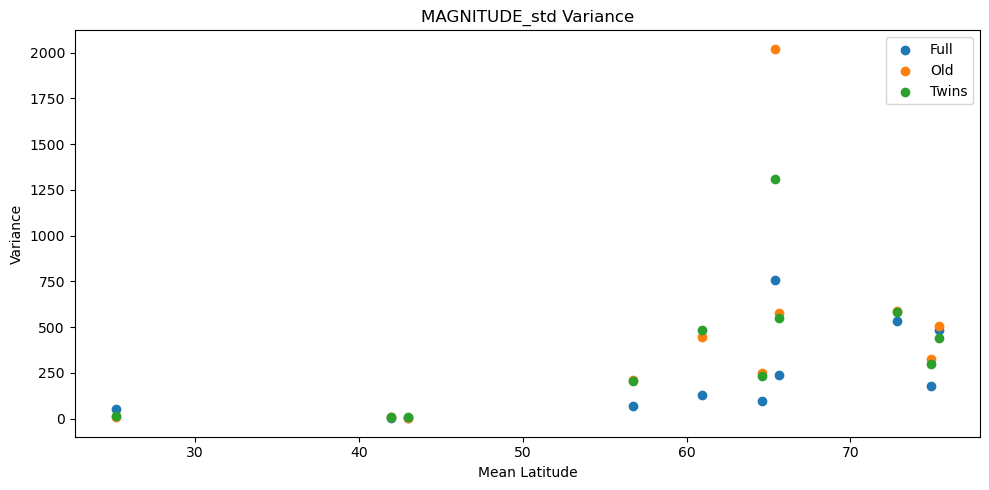

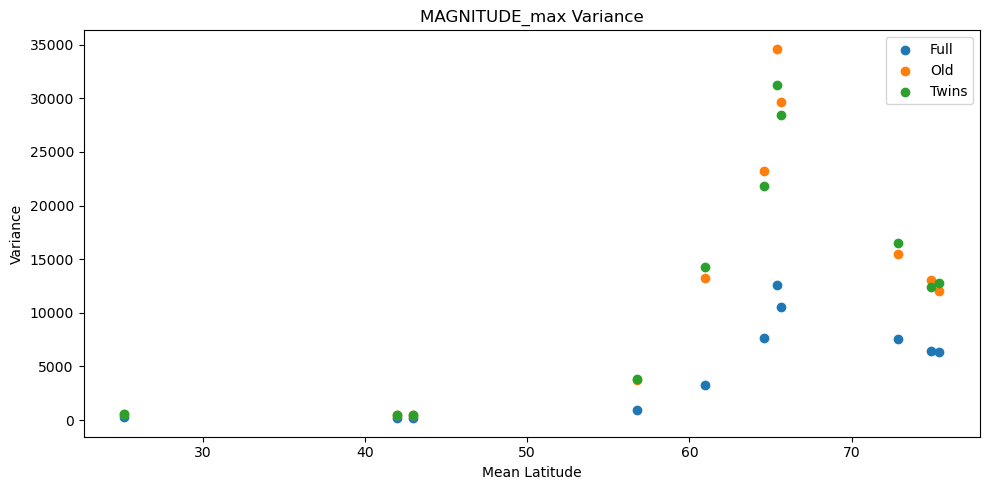

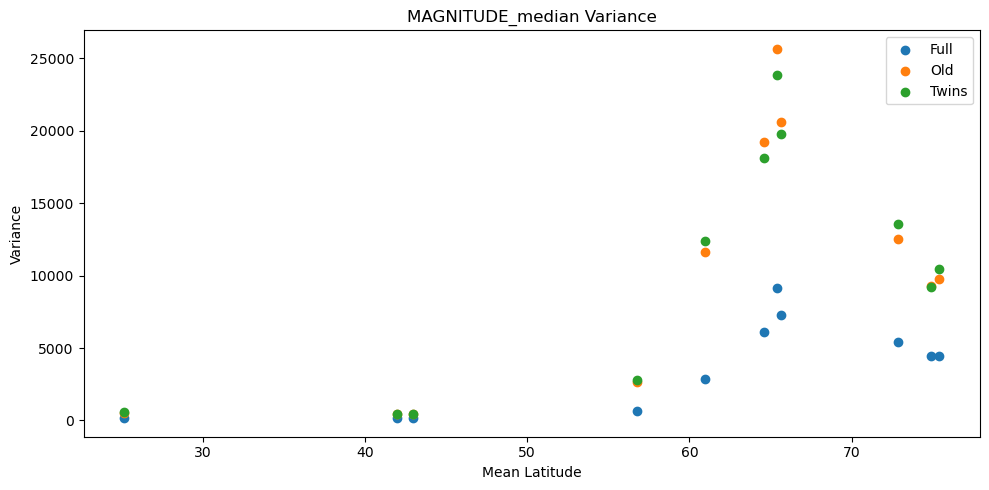

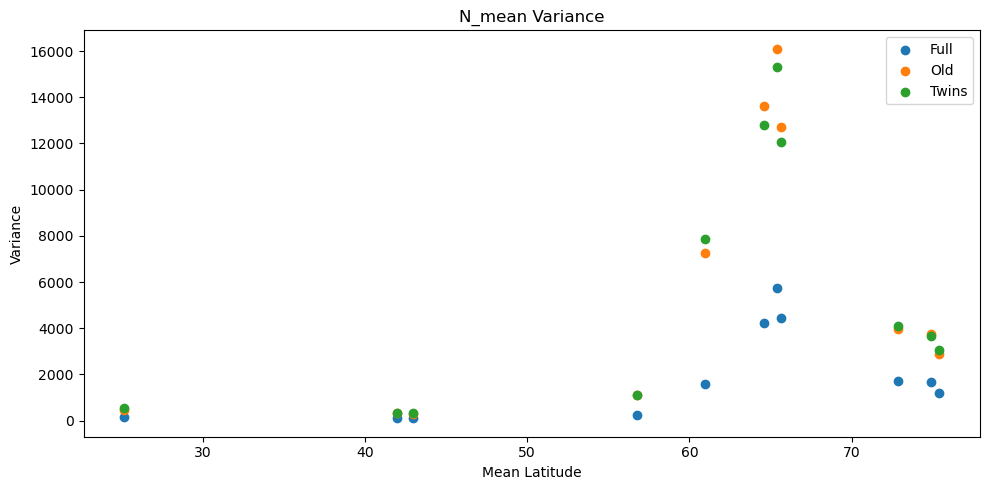

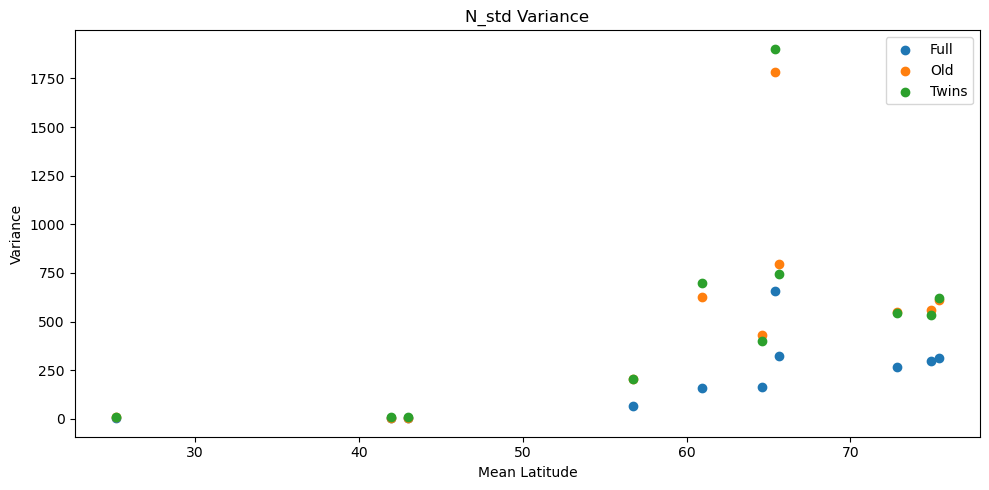

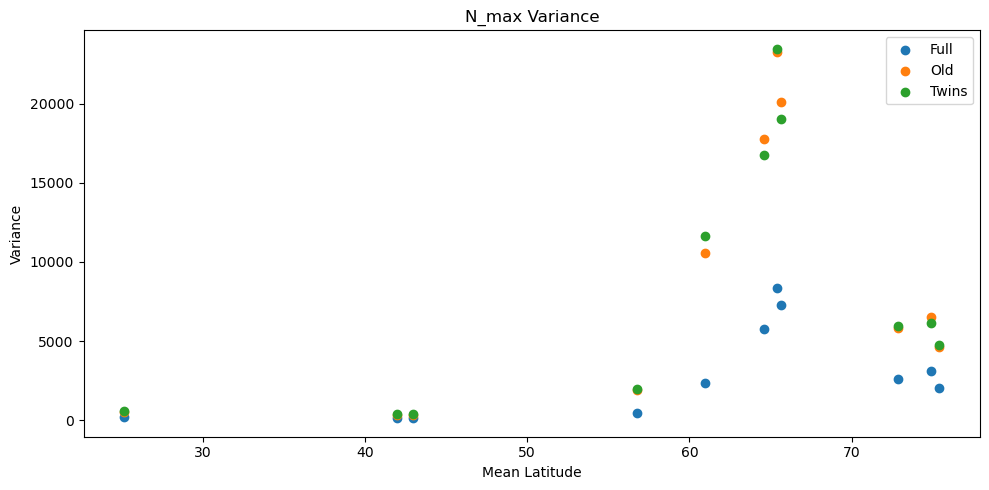

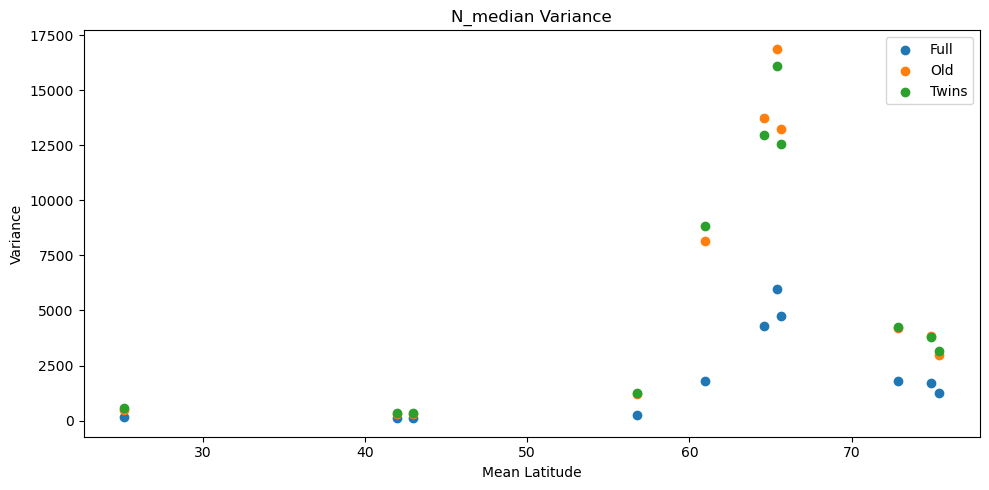

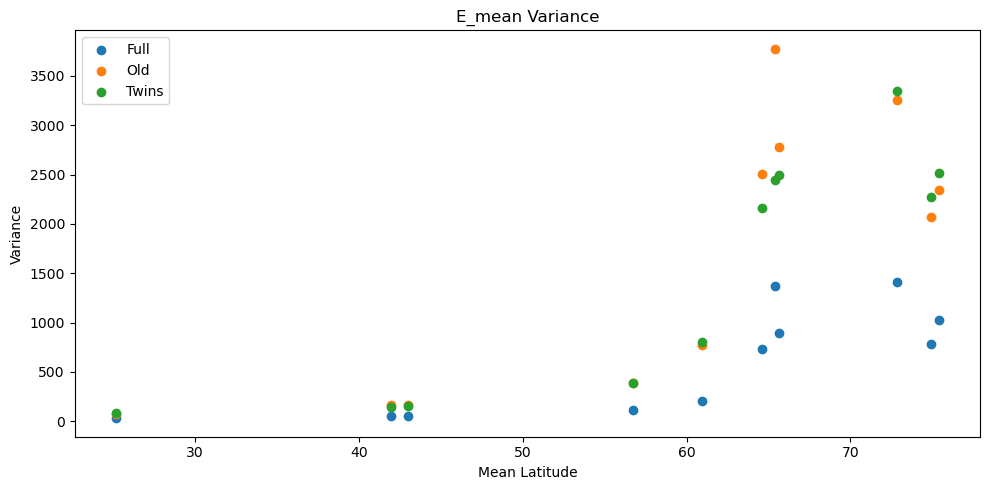

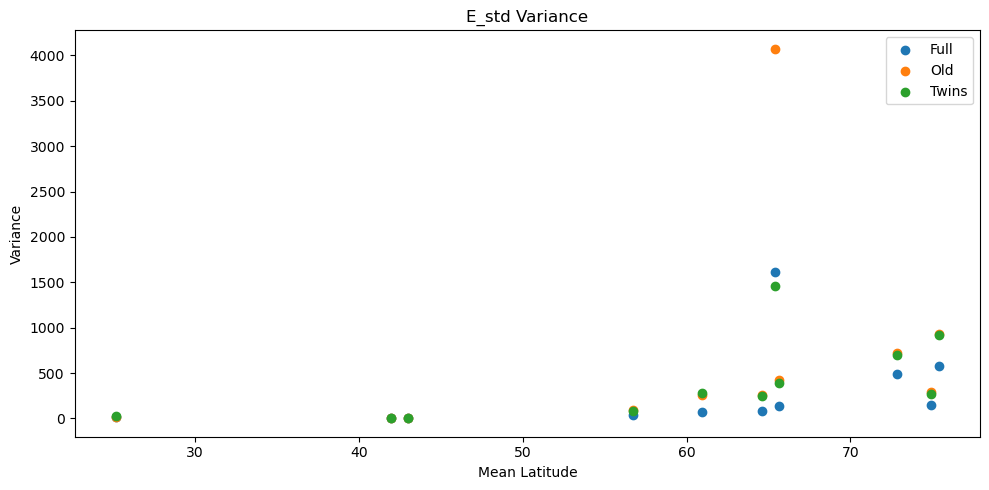

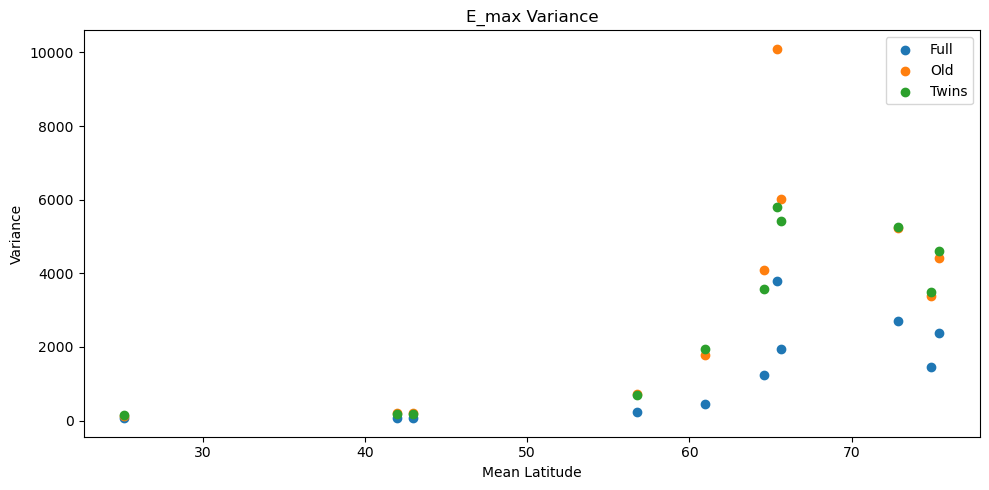

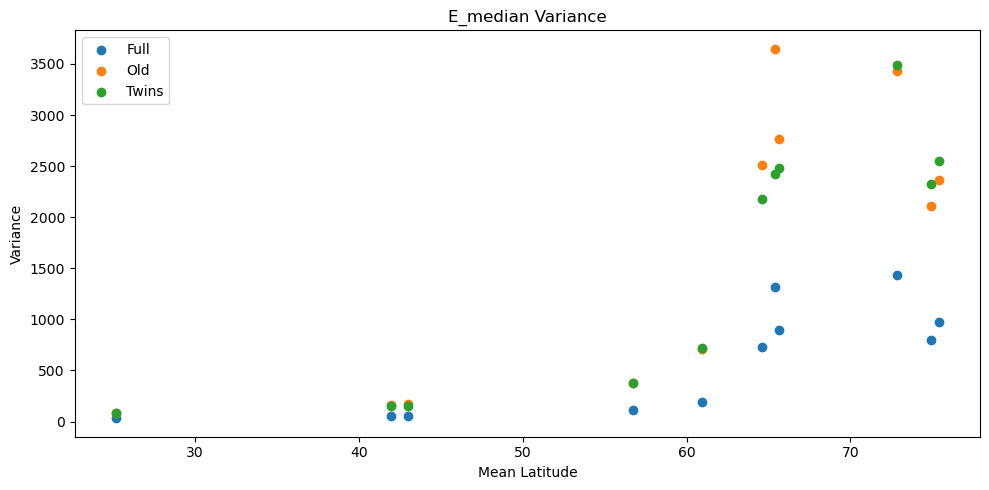

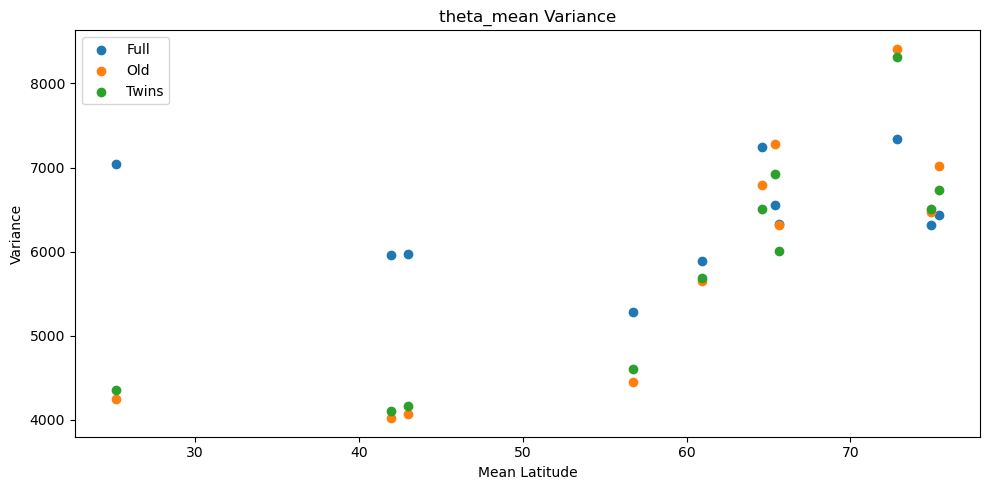

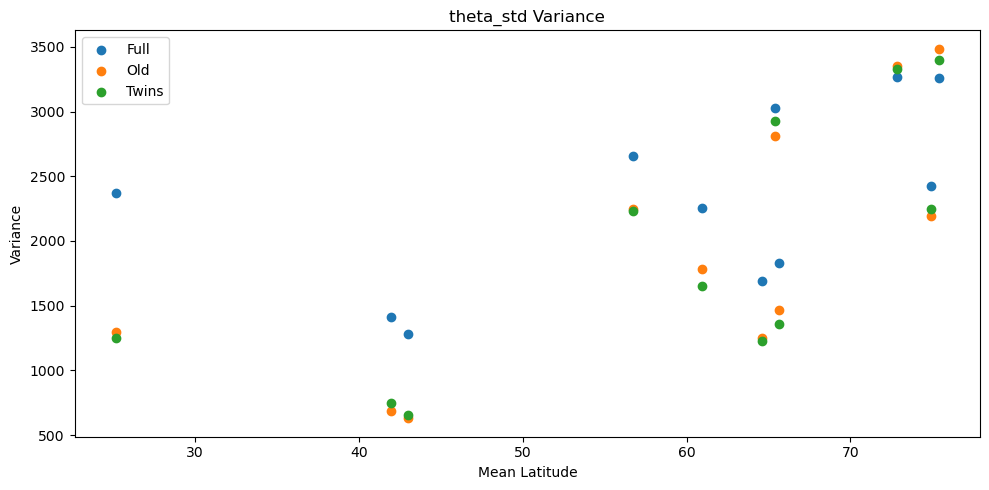

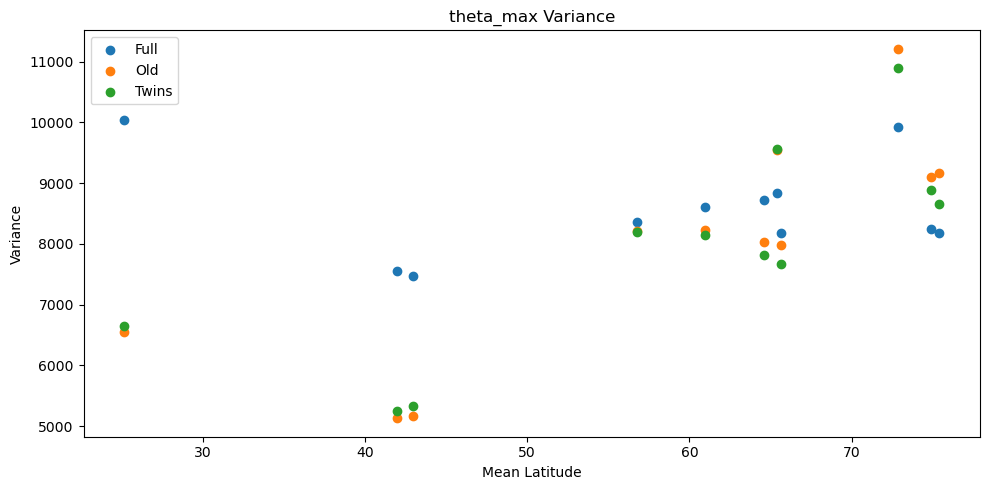

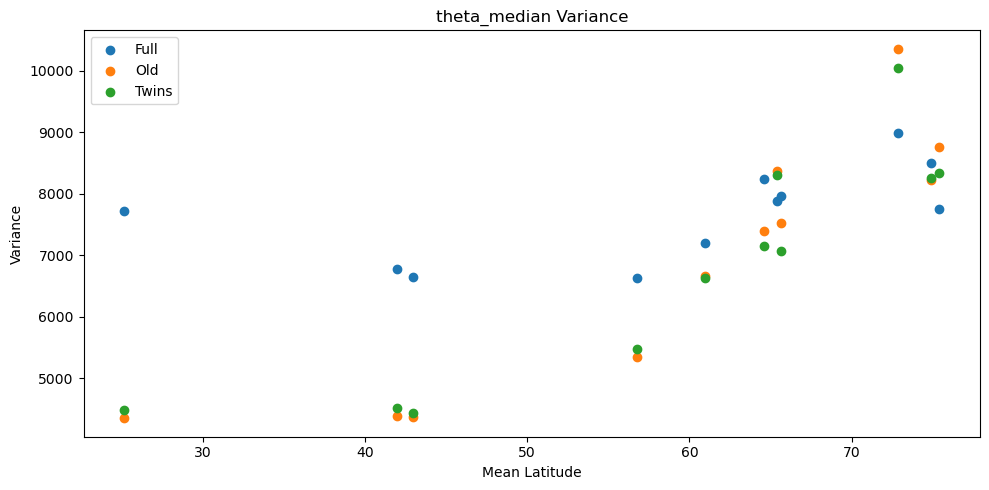

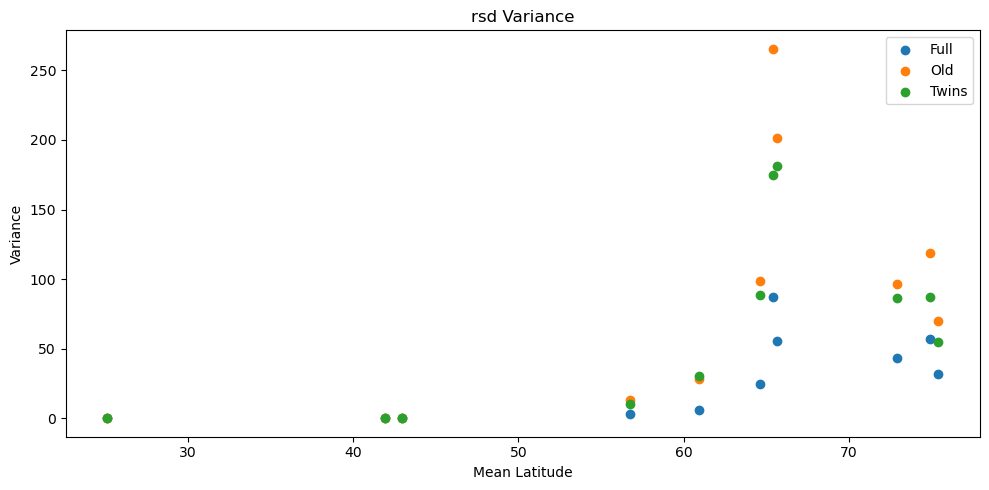

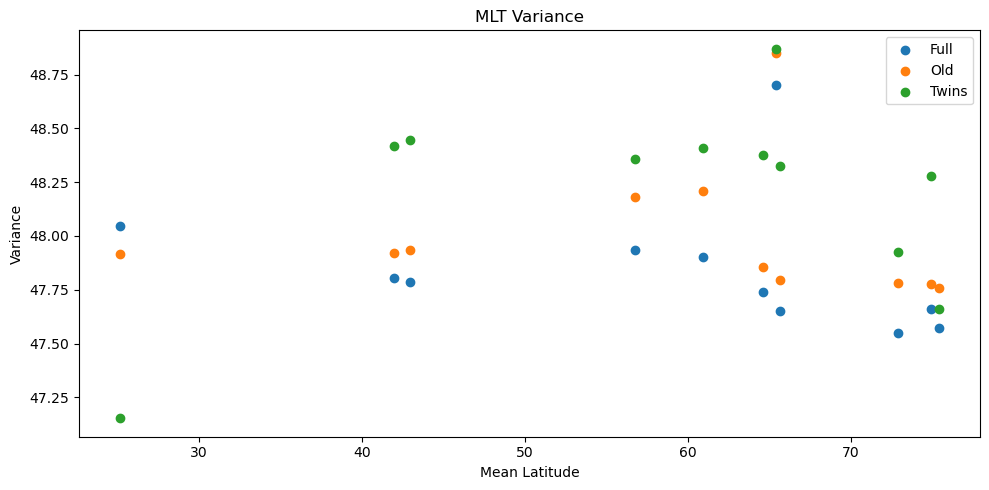

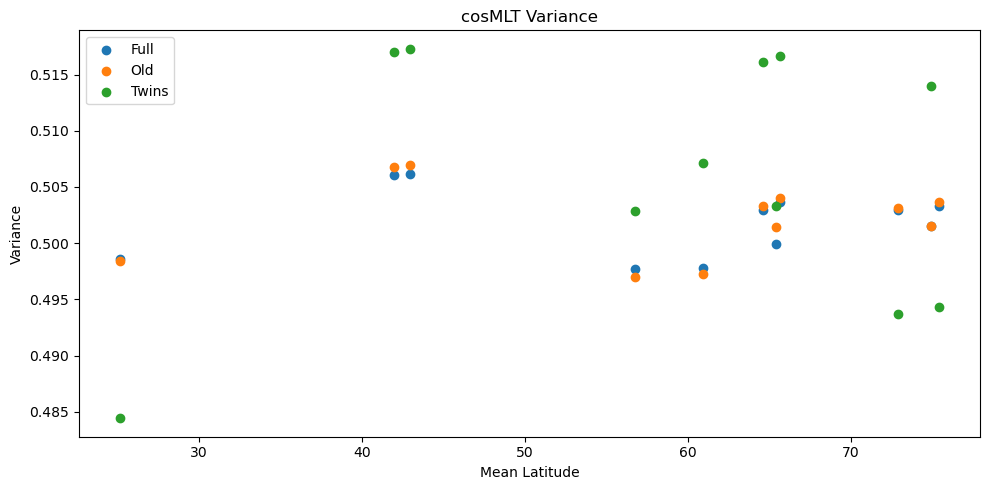

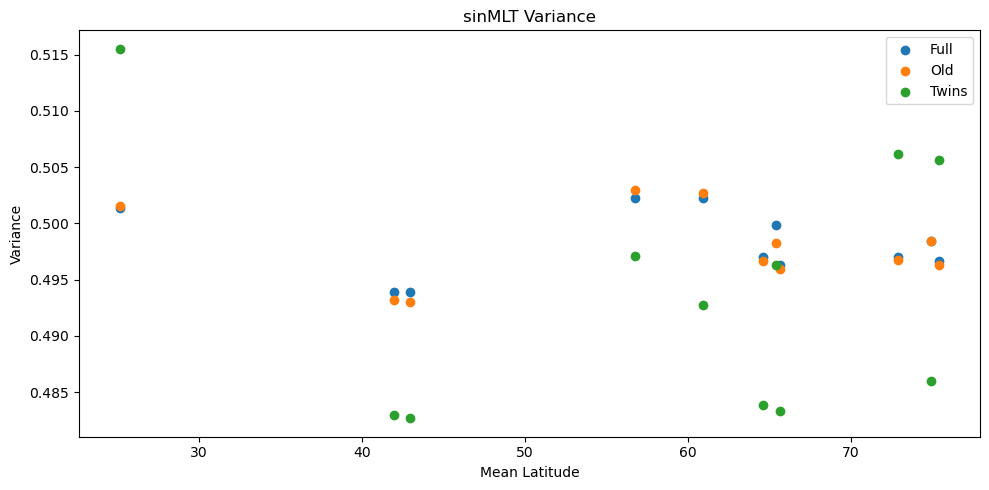

In [ ]:
x = [mag_variances[region]['mean_lat'] for region in mag_variances.keys()]

for param in mag_variances['region_194']['full_var'].index:

	full_y = [mag_variances[region]['full_var'][param] for region in mag_variances.keys()]
	old_y = [mag_variances[region]['old_var'][param] for region in mag_variances.keys()]
	twins_y = [mag_variances[region]['twins_var'][param] for region in mag_variances.keys()]

	fig = plt.figure(figsize=(10, 5))
	ax = fig.add_subplot(111)
	plt.scatter(x, full_y, label='Full')
	plt.scatter(x, old_y, label='Old')
	plt.scatter(x, twins_y, label='Twins')

	ax.set_title(f'{param} Variance')
	ax.set_ylabel('Variance')
	ax.set_xlabel('Mean Latitude')
	ax.legend()
	plt.tight_layout()

	plt.show()


In [ ]:
for region in mag_correlation_dict.keys():

	print(region)
	print(mag_correlation_dict[region]['twins_corr'])

region_194
['dbht_mean', 'dbht_std', 'dbht_median', 'MAGNITUDE_mean', 'MAGNITUDE_std', 'MAGNITUDE_max', 'MAGNITUDE_median', 'N_mean', 'N_std', 'N_median', 'E_mean', 'E_std', 'E_max', 'theta_mean', 'theta_median', 'rsd', 'sinMLT']
region_270
['dbht_mean', 'dbht_std', 'dbht_median', 'MAGNITUDE_mean', 'MAGNITUDE_std', 'MAGNITUDE_max', 'MAGNITUDE_median', 'N_mean', 'N_median', 'E_mean', 'E_max', 'theta_mean', 'theta_median', 'rsd', 'sinMLT']
region_287
['dbht_mean', 'dbht_std', 'dbht_median', 'MAGNITUDE_mean', 'MAGNITUDE_std', 'MAGNITUDE_max', 'MAGNITUDE_median', 'N_mean', 'N_median', 'E_mean', 'E_max', 'theta_mean', 'theta_median', 'MLT']
region_207
['dbht_mean', 'dbht_std', 'dbht_median', 'MAGNITUDE_mean', 'MAGNITUDE_std', 'MAGNITUDE_max', 'MAGNITUDE_median', 'N_mean', 'N_median', 'E_mean', 'E_median', 'theta_mean', 'theta_median', 'MLT']
region_62
['dbht_mean', 'dbht_std', 'dbht_median', 'MAGNITUDE_mean', 'MAGNITUDE_max', 'MAGNITUDE_median', 'N_mean', 'N_std', 'N_median', 'E_mean', 'E_m

In [ ]:
for region in regions:
	col_list = []
	for col in regions[region]['regional_df'].columns:
		if col not in mag_correlation_dict[region]['twins_corr']:
			col_list.append(col)
	print(f'{region}: {col_list}')

region_194: ['dbht_max', 'N_max', 'E_median', 'theta_std', 'theta_max', 'rolling_rsd', 'MLT', 'cosMLT']
region_270: ['dbht_max', 'N_std', 'N_max', 'E_std', 'E_median', 'theta_std', 'theta_max', 'rolling_rsd', 'MLT', 'cosMLT']
region_287: ['dbht_max', 'N_std', 'N_max', 'E_std', 'E_median', 'theta_std', 'theta_max', 'rsd', 'rolling_rsd', 'cosMLT', 'sinMLT']
region_207: ['dbht_max', 'N_std', 'N_max', 'E_std', 'E_max', 'theta_std', 'theta_max', 'rsd', 'rolling_rsd', 'cosMLT', 'sinMLT']
region_62: ['dbht_max', 'MAGNITUDE_std', 'N_max', 'E_std', 'E_median', 'theta_std', 'theta_max', 'rsd', 'rolling_rsd', 'cosMLT', 'sinMLT']
region_241: ['dbht_max', 'MAGNITUDE_std', 'N_std', 'N_max', 'E_std', 'theta_std', 'theta_max', 'rolling_rsd', 'MLT', 'cosMLT']
region_366: ['dbht_max', 'N_max', 'theta_std', 'theta_max', 'rolling_rsd', 'MLT', 'cosMLT']
region_387: ['dbht_max', 'E_max', 'theta_std', 'theta_max', 'rolling_rsd', 'MLT', 'cosMLT']
region_223: ['dbht_max', 'MAGNITUDE_std', 'N_std', 'N_max', 'E_